## Семинар 1: MDP + CrossEntropy
### Майнор ВШЭ, 17.01.2019

Обучение с подкреплением (RL) является направлением машинного обучения и изучает взаимодействие агента, которому необходимо максимизировать долговременный выигрыш в некоторой среде. Агенту не сообщается сведений о правильности действий, как в большинстве задач машинного обучения, вместо этого агент должен определить выгодные действия самостоятельно испробовав их. Испытание действий и отсроченная награда являются основными отличительными признаками RL.

<img src="rl_simple.png" style="width: 400px;"/>

<img src="rl_intro.png" style="width: 300px;"/>

Основные составляющие модели RL:
* $s_t$ - состояние среды в момент времени $t$,
* $a_t$ - действие, совершаемое агентом в момент времени $t$,
* $r_t$ - вознаграждение, получаемое агентом при совершении действия $a_t$,
* $\pi$ - стратегия агента - последовательность действий или план.

В простейших моделях RL среда представляется в виде марковского процесса, где функция перехода определяется как $P(s' |s,a)$, что означает вероятность оказаться в состоянии $s'$ при совершении действия $a$ в состоянии $s$. Вознаграждение теперь определяется как $r(s,a,s')$.

<img src="mdp.png" style="width: 400px;"/>

Будем пользоваться стандартными средами, реализованными в библиотеке OpenAI Gym (https://gym.openai.com).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\panov\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space: Box(2,)
Action space: Discrete(3)


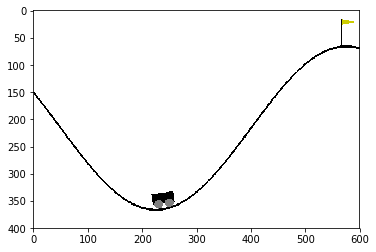

In [2]:
import gym
env = gym.make("MountainCar-v0")

plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
env.close()

### Gym interface

Основные методы класса __Env__:
* __reset()__ - инициализация окружения в начальном состоянии _возвращает первое наблюдение_,
* __render()__ - показать текущее состояние среды,
* __step(a)__ - выполнить действие __a__ и получить (new observation, reward, is done, info)
 * _new observation_ - новое наблюдение после выполнения действия __a__,
 * _reward_ - вознагрждение (скаляр) за выполненное действие __a__,
 * _is done_ - True, если процесс (марковский!) завершился, False иначе,
 * _info_ - дополнительная информация.

In [3]:
obs0 = env.reset()
print("initial observation code:", obs0)
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)

print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

initial observation code: [-0.47213021  0.        ]
taking action 2 (right)
new observation code: [-0.47151469  0.00061552]
reward: -1.0
is game over?: False


### Задание 1
Наша цель, чтобы тележка достигла флага. Модифицируйте код ниже для выполнения этого задания:

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


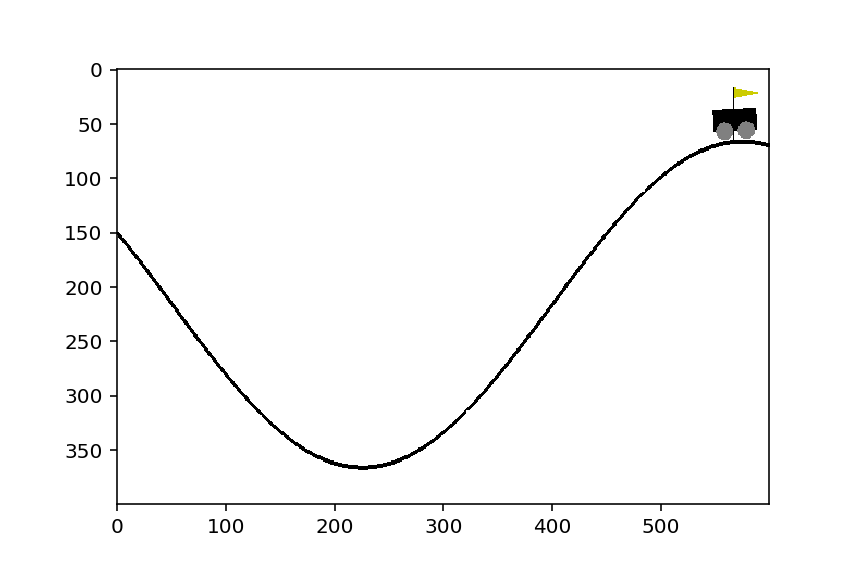

Well done!
You solved it!


In [5]:
TIME_LIMIT = 250
env = gym.wrappers.TimeLimit(gym.envs.classic_control.MountainCarEnv(),
                             max_episode_steps=TIME_LIMIT + 1)
s = env.reset()
actions = {'left': 0, 'stop': 1, 'right': 2}

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for t in range(TIME_LIMIT):
    if s[1] > 0:
        s, r, done, _ = env.step(actions['right'])
    else:
        s, r, done, _ = env.step(actions['left'])

    #draw game image on display
    ax.clear()
    ax.imshow(env.render('rgb_array'))
    fig.canvas.draw()
    
    if done:
        print("Well done!")
        break
else:    
    print("Time limit exceeded. Try again.")
    
env.close()
assert s[0] > 0.47
print("You solved it!")


## Вероятностный подход к RL

Пусть наша стратегия - это вероятностное распределение:

$\pi(s,a) = P(a|s)$

Рассмотрим пример с задачей Taxi [Dietterich, 2000]. Для нее мы можем считать, что наша стратегия - это двумерный массив.

In [6]:
env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [7]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


### Задание 2

Создадим "равномерную" стратегию в виде двумерного массива с равномерным рапсределением по действиям и сгенерируем игровую сессию с такой стратегией.

In [8]:
policy = np.array([[1./n_actions for _ in range(n_actions)] for _ in range(n_states)])

assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

In [9]:
def generate_session(policy,t_max=10**4):
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, p=policy[s])
        
        new_s,r,done,info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward

In [10]:
s,a,r = generate_session(policy)

Наша задача - выделить лучшие действия и состояния, т.е. такие, при которых было лучшее вознаграждение:

In [11]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    print(reward_threshold)
    elite_states  = [session for session_i, session in enumerate(states_batch) 
                     if rewards_batch[session_i] >= reward_threshold]
    elite_states = [state for session in elite_states for state in session]
    elite_actions = [session for session_i, session in enumerate(actions_batch) 
                     if rewards_batch[session_i] >= reward_threshold]
    elite_actions = [action for session in elite_actions for action in session]
    
    return elite_states,elite_actions

In [12]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

3.0
3.6
4.8
5.0
Ok!


Теперь мы хотим написать обновляющуюся стратегию

In [13]:
def update_policy(elite_states,elite_actions):
    """
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    for state in range(n_states):
        occur = 0
        for pos, s in enumerate(elite_states):
            if s == state:
                new_policy[state, elite_actions[pos]] += 1
                occur += 1
        if occur > 0:
            for a in range(n_actions):
                new_policy[state, a] /= occur
        else:
            for a in range(n_actions):
                new_policy[state, a] = 1./n_actions
       
    
    return new_policy

In [14]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


Визуализириуем наш процесс обучения и будем измерять распределение получаемых за сессию вознаграждений 

In [15]:
from IPython.display import clear_output

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend(loc=4)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend(loc=1)
    plt.grid()

    plt.show()

mean reward = -36.016, threshold=7.000


<IPython.core.display.Javascript object>


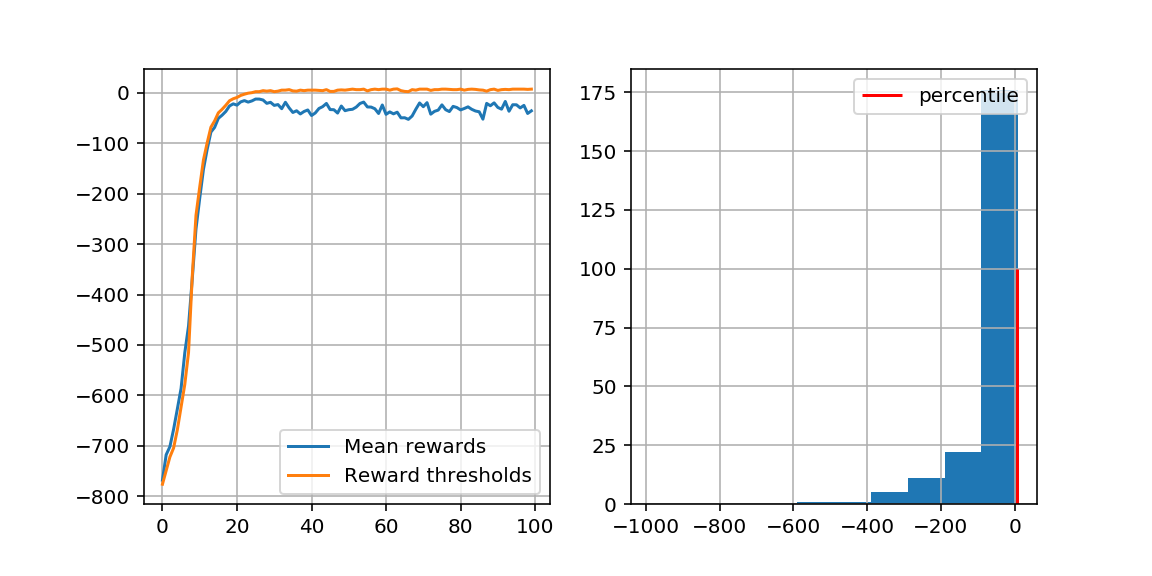

In [16]:
policy = np.ones([n_states,n_actions])/n_actions 
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch, percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy
    
    #display results on chart
    show_progress(rewards_batch,log)

### Задание 3

Попробуем заменить метод обновления вероятностей на нейронную сеть. Будем тестировать нашего нового агента на известной задаче перевернутого маятника с непрерывным множеством действий.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\Users\panov\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


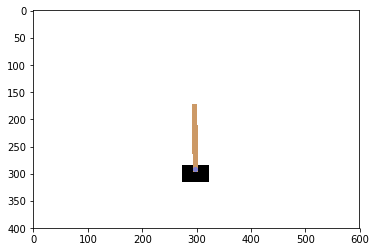

In [17]:
env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [19]:
env.close()

In [20]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state and amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))

C:\Users\panov\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

In [21]:
env.reset()

array([-0.0418147 ,  0.00587579, -0.03832922,  0.03398233])

In [22]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward

mean reward = 998.870, threshold=1000.000


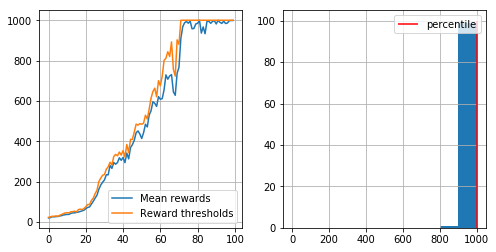

You Win! You may stop training now via KeyboardInterrupt.


In [23]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    #sessions = [<generate a list of n_sessions new sessions>]
    sessions = [generate_session() for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = map(np.array,zip(*sessions))

    #elite_states, elite_actions = <select elite actions just like before>
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch, percentile)
    
    #<fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states, elite_actions)
    
    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [24]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

C:\Users\panov\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [26]:
env.close()

In [27]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices